# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4054.172334,1.0001,-131.886217,1869.26,1737.373783
OMUSDT,526.319895,1765.635037,0.4355,0.000000,1239.32,1239.320000
BTCUSDT,601.021649,873.129447,0.2154,3.537078,272.11,275.647078
JASMYUSDT,387.458505,512.355718,0.1264,0.000000,124.90,124.900000
SOLUSDT,281.200518,417.799897,0.1031,0.000000,136.60,136.600000
ETHUSDT,250.747339,268.594459,0.0663,0.000000,17.85,17.850000
TRXUSDT,76.868953,162.605097,0.0401,-10.723889,85.74,75.016111
BBUSDT,60.176053,52.792931,0.0130,-39.733101,-7.38,-47.113101
BNBUSDT,1.142121,1.259743,0.0003,-10.606040,0.12,-10.486040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-11-29    1338.021317
2024-11-30    1400.498824
2024-12-01    1387.700221
2024-12-02    1418.524583
2024-12-03    1806.096259
Name: Total, Length: 72, dtype: float64

In [24]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

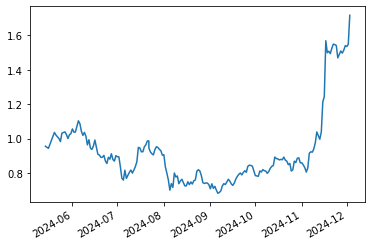

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MANAUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.2881
TRXUSDT,0.1940
XLMUSDT,0.1737
BNBUSDT,0.1433
PEPEUSDT,0.0886
SUIUSDT,0.0671
XRPUSDT,0.0330
AAVEUSDT,0.0114
JASMYUSDT,0.0009
BONKUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.322389
BTCUSDT,0.300000
TRXUSDT,0.135103
XLMUSDT,0.092561
PEPEUSDT,0.064170
BNBUSDT,0.051798
SUIUSDT,0.030608
JASMYUSDT,0.002328
XRPUSDT,0.001042


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.411038
OMUSDT,0.313276
TRXUSDT,0.275686


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1765.635037,0.435511,0.313276,0.122235
BTCUSDT,873.129447,0.215366,0.411038,-0.195672
JASMYUSDT,512.355718,0.126377,0.000000,0.000000
SOLUSDT,417.799897,0.103054,0.000000,0.000000
ETHUSDT,268.594459,0.066251,0.000000,0.000000
TRXUSDT,162.605097,0.040108,0.275686,-0.235578
BBUSDT,52.792931,0.013022,0.000000,0.000000
BNBUSDT,1.259743,0.000311,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1765.635037,0.435511,0.322389,0.113122
BTCUSDT,873.129447,0.215366,0.300000,-0.084634
JASMYUSDT,512.355718,0.126377,0.002328,0.124049
SOLUSDT,417.799897,0.103054,0.000000,0.000000
ETHUSDT,268.594459,0.066251,0.000000,0.000000
TRXUSDT,162.605097,0.040108,0.135103,-0.094995
BBUSDT,52.792931,0.013022,0.000000,0.000000
BNBUSDT,1.259743,0.000311,0.051798,-0.051487
PEPEUSDT,0.000005,0.000000,0.064170,-0.064170
XLMUSDT,0.000000,0.000000,0.092561,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

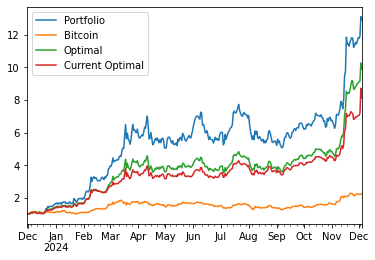

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

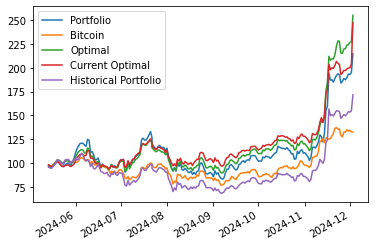

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-24,193.169710,135.911726,227.809498,203.483608,154.123725
2024-11-25,183.971899,128.947631,215.449277,193.220719,146.949156
2024-11-26,185.900806,127.490870,215.324051,194.561951,148.874744
2024-11-27,188.862397,132.783198,219.833777,197.386092,150.943684
2024-11-28,187.397946,132.479326,220.200670,197.093293,149.674755
2024-11-29,189.762038,134.971167,223.966027,198.858805,151.414174
2024-11-30,193.499425,133.506331,224.197419,199.777261,154.042164
2024-12-01,193.004982,134.578273,226.782644,200.051675,153.524639
2024-12-02,195.100137,132.703379,227.229053,203.951716,154.867822
2024-12-03,214.774225,132.715937,255.210580,247.544351,171.684779


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.571401
 dtype: float64,
 0.5721467381579118)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.634609
 dtype: float64,
 0.6346093550711247)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.706603
Bitcoin            0.436331
Optimal            0.572147
Current Optimal    0.549237
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44740125411648435

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.090714,0.051798,0.007604,0.021302,0.001873,0.019429
BTCUSDT,0.382347,0.300000,0.036410,0.151263,0.052343,0.098920
JASMYUSDT,0.006199,0.002328,0.000455,0.001799,0.000019,0.001780
OMUSDT,16.473080,0.322389,0.896204,0.629889,0.523889,0.106000
PEPEUSDT,0.345626,0.064170,0.021867,0.071853,0.020329,0.051524
SUIUSDT,0.068646,0.030608,0.005296,0.020299,0.002586,0.017714
TRXUSDT,0.197699,0.135103,0.017758,0.055354,0.025422,0.029932
XLMUSDT,0.174324,0.092561,0.014241,0.047728,0.015227,0.032501
XRPUSDT,0.002049,0.001042,0.000165,0.000513,0.000001,0.000511


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.793729,0.313276,0.484683,0.536961,0.420968,0.115993
BTCUSDT,0.190267,0.411038,0.263271,0.187846,0.108692,0.079154
TRXUSDT,0.299982,0.275686,0.252046,0.275193,0.214833,0.060360


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.103764,0.435644,0.654994,0.661394,0.538653,0.122741
BTCUSDT,0.100828,0.217822,0.135581,0.089952,0.020197,0.069755
JASMYUSDT,0.062295,0.128713,0.081271,0.121773,0.040411,0.081362
SOLUSDT,0.033460,0.099010,0.056364,0.069927,0.010116,0.059810
ETHUSDT,0.011444,0.069307,0.034358,0.032594,0.003563,0.029031
TRXUSDT,0.043094,0.039604,0.035187,0.014189,0.002934,0.011255
BBUSDT,-0.004622,0.009901,0.002246,0.010172,0.000393,0.009779


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.0465888390201616, -0.06679430782433853)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04731784152327949, -0.0670643674430112)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.016951
BTCUSDT     -0.011161
JASMYUSDT   -0.010454
SOLUSDT     -0.007548
ETHUSDT      0.001090
TRXUSDT     -0.002469
BBUSDT      -0.000123
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047615
Name: 2024-11-25 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.038608
BTCUSDT     -0.007433
JASMYUSDT   -0.010513
SOLUSDT     -0.006534
ETHUSDT     -0.002583
TRXUSDT     -0.000650
BBUSDT      -0.000744
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067064
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.059283578762158805, -0.07598515697134703)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06575570771527885, -0.08428063684469667)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053231110166252135, -0.06920553308192683)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05989300071716513, -0.07686813622850826)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.038497
BTCUSDT     -0.005893
JASMYUSDT   -0.007942
SOLUSDT     -0.004818
ETHUSDT     -0.002284
TRXUSDT     -0.000756
BBUSDT      -0.000597
Portfolio   -0.060786
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052258799143130426, -0.06790513590000335)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060927018679071625, -0.07767189880353186)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.041364
BTCUSDT     -0.005249
JASMYUSDT   -0.007149
SOLUSDT     -0.003982
ETHUSDT     -0.001770
TRXUSDT     -0.000581
BBUSDT      -0.000680
Portfolio   -0.060775
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05250001468843722, -0.06789818130147723)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061275484410298245, -0.07792292345305038)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039707
BTCUSDT     -0.005910
JASMYUSDT   -0.008524
SOLUSDT     -0.004533
ETHUSDT     -0.001973
TRXUSDT     -0.000728
BBUSDT      -0.000613
Portfolio   -0.061987
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

C:\Users\Admin\AppData\Local\Temp\ipykernel_604\2713009761.py:4: RuntimeWarning: Mean of empty slice.
  cvar=perf[perf<var].mean()
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10480214378541335, -0.15277644027878745)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -1.011706e-01
BTCUSDT     -9.465998e-07
JASMYUSDT   -4.817470e-03
SOLUSDT     -7.127954e-04
ETHUSDT     -1.486954e-04
TRXUSDT     -1.533957e-04
BBUSDT      -2.139796e-04
Portfolio   -1.072179e-01
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060800085166956765, -0.07620630151648054)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06911943457399496, -0.08545796581958211)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.043474
BTCUSDT     -0.005606
JASMYUSDT   -0.009419
SOLUSDT     -0.004468
ETHUSDT     -0.002348
TRXUSDT     -0.001127
BBUSDT      -0.000739
Portfolio   -0.067180
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.047258,-0.081809,-0.069987,-0.024508
2024-01-15,-0.047258,-0.081803,-0.071296,0.013188
2024-01-16,-0.047258,-0.081559,-0.068548,0.038454
2024-01-17,-0.047258,-0.083043,-0.071153,-0.023871
2024-01-18,-0.047258,-0.085138,-0.073708,-0.031876
...,...,...,...,...
2024-11-30,-0.046340,-0.107267,-0.087051,0.001033
2024-12-01,-0.046340,-0.107036,-0.081966,0.011531
2024-12-02,-0.046340,-0.106015,-0.082994,0.001968
2024-12-03,-0.046340,-0.112554,-0.085750,0.123142


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034448,-0.084213,-0.076914,-0.017293
2024-05-29,-0.034448,-0.081607,-0.074872,-0.008712
2024-05-30,-0.034448,-0.071650,-0.067423,0.037471
2024-05-31,-0.034448,-0.072567,-0.064255,0.038073
2024-06-01,-0.034448,-0.075909,-0.066203,0.052033
...,...,...,...,...
2024-11-30,-0.046076,-0.136644,-0.117785,0.019695
2024-12-01,-0.046076,-0.136705,-0.122617,-0.002555
2024-12-02,-0.046076,-0.046702,-0.046366,0.010855
2024-12-03,-0.042721,-0.071098,-0.061364,0.100841


<AxesSubplot:>

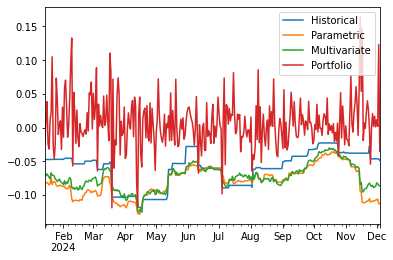

In [80]:
var_data.plot()

<AxesSubplot:>

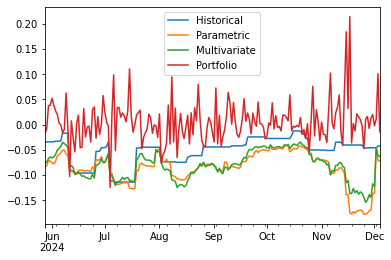

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021472,0.009202,0.01227
Kupiec Stat,7.042947,17.007844,13.843197
P-value,0.007958,0.000037,0.000199


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.062827,0.015707,0.015707
Kupiec Stat,0.614003,6.386075,6.386075
P-value,0.433285,0.011502,0.011502


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77202542, 0.07479914, 0.05639555, 0.052761  , 0.04401889])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014784
ADAUSDT     0.014877
ALGOUSDT    0.016811
APTUSDT     0.015506
ARBUSDT     0.016512
              ...   
WBTCUSDT    0.009408
WLDUSDT     0.021454
XLMUSDT     0.011891
XRPUSDT     0.010290
XTZUSDT     0.015745
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

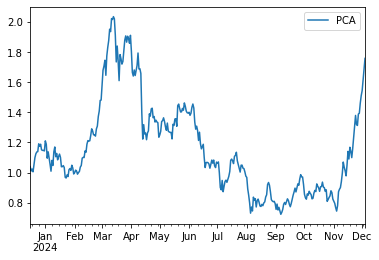

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

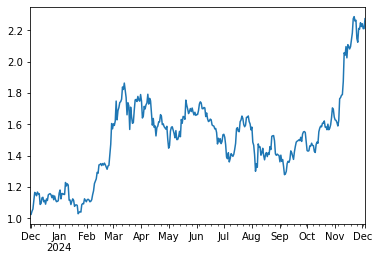

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.399598
ETHUSDT      0.414676
WBETHUSDT    0.414713
EGLDUSDT     0.415549
               ...   
FLOKIUSDT    1.113164
WLDUSDT      1.120304
BONKUSDT     1.123314
PEPEUSDT     1.153332
OMUSDT       1.527625
Length: 65, dtype: float64

<AxesSubplot:>

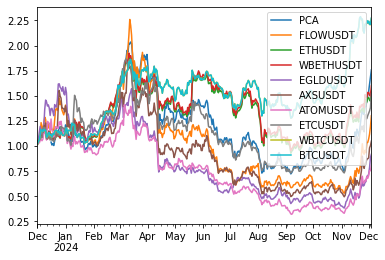

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

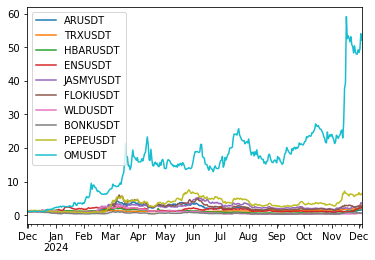

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5399088 , 0.15668391, 0.13368448, 0.10788988, 0.06183293])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.101999
BTCUSDT      0.063802
JASMYUSDT    0.158463
SOLUSDT      0.103012
ETHUSDT      0.084758
TRXUSDT      0.040686
BBUSDT       0.214441
BNBUSDT      0.067944
PEPEUSDT     0.164894
Name: PC1, dtype: float64

<AxesSubplot:>

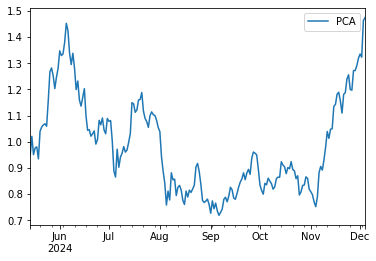

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

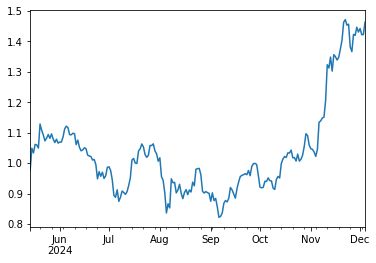

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.378386
ETHUSDT      0.388500
BNBUSDT      0.399053
BTCUSDT      0.405751
JASMYUSDT    0.540578
PEPEUSDT     0.660233
BBUSDT       0.701335
OMUSDT       0.862327
TRXUSDT      0.874936
dtype: float64

<AxesSubplot:>

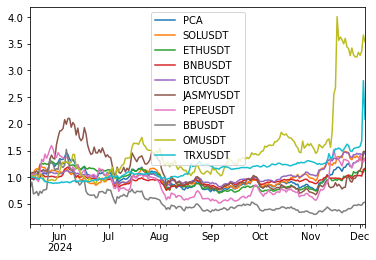

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.908574
BBUSDT       1.531311
JASMYUSDT    1.255764
SOLUSDT      1.147148
BTCUSDT      1.000000
ETHUSDT      0.948424
OMUSDT       0.874894
BNBUSDT      0.652089
TRXUSDT      0.235900
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.699155
SOLUSDT      1.341558
BTCUSDT      1.000000
ETHUSDT      0.933740
BNBUSDT      0.549061
BBUSDT       0.545375
JASMYUSDT    0.228970
OMUSDT      -0.274610
TRXUSDT     -0.694788
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table

,Beta
OMUSDT,0.057702
BTCUSDT,0.700602
JASMYUSDT,0.359829
SOLUSDT,-0.266419
ETHUSDT,0.268471
TRXUSDT,0.014104
BBUSDT,0.232925
BNBUSDT,-0.424456
PEPEUSDT,-0.015291


In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.548442407326453

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.209271
BTCUSDT      1.209489
JASMYUSDT    0.475427
SOLUSDT      0.759604
ETHUSDT      0.928426
TRXUSDT      0.134983
BBUSDT       0.331518
BNBUSDT      1.070199
PEPEUSDT     0.373243
PCA          1.000000
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.112514
BTCUSDT      0.625224
JASMYUSDT    0.250037
SOLUSDT      0.506614
ETHUSDT      0.297851
TRXUSDT      0.041608
BBUSDT       0.395298
BNBUSDT      0.502873
PEPEUSDT     0.261245
PCA          1.000000
dtype: float64

In [104]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.297183,0.161269,0.353472,0.226893,0.132359,0.266717,0.207583,0.170411
BTCUSDT,0.297183,1.000000,0.510601,0.707843,0.789133,0.152438,0.554288,0.595199,0.655070
JASMYUSDT,0.161269,0.510601,1.000000,0.468030,0.498696,0.254916,0.602074,0.481114,0.397765
SOLUSDT,0.353472,0.707843,0.468030,1.000000,0.657196,0.170518,0.548205,0.512144,0.544987
ETHUSDT,0.226893,0.789133,0.498696,0.657196,1.000000,0.121556,0.602978,0.583688,0.642567
TRXUSDT,0.132359,0.152438,0.254916,0.170518,0.121556,1.000000,0.124479,0.299161,0.102631
BBUSDT,0.266717,0.554288,0.602074,0.548205,0.602978,0.124479,1.000000,0.579672,0.474891
BNBUSDT,0.207583,0.595199,0.481114,0.512144,0.583688,0.299161,0.579672,1.000000,0.416938
PEPEUSDT,0.170411,0.655070,0.397765,0.544987,0.642567,0.102631,0.474891,0.416938,1.000000


In [105]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.177828,0.300548,0.049854,-0.509540,0.715113,0.169542,0.366102,-0.336716
BTCUSDT,-0.177828,1.000000,0.061178,0.839101,0.571701,-0.087337,0.248609,0.339589,0.731497
JASMYUSDT,0.300548,0.061178,1.000000,0.373135,0.110162,0.671483,0.538977,0.771900,0.127892
SOLUSDT,0.049854,0.839101,0.373135,1.000000,0.549122,0.293476,0.569308,0.611109,0.739547
ETHUSDT,-0.509540,0.571701,0.110162,0.549122,1.000000,-0.254090,0.498338,0.207262,0.660174
TRXUSDT,0.715113,-0.087337,0.671483,0.293476,-0.254090,1.000000,0.363805,0.787799,-0.113977
BBUSDT,0.169542,0.248609,0.538977,0.569308,0.498338,0.363805,1.000000,0.592661,0.347132
BNBUSDT,0.366102,0.339589,0.771900,0.611109,0.207262,0.787799,0.592661,1.000000,0.333297
PEPEUSDT,-0.336716,0.731497,0.127892,0.739547,0.660174,-0.113977,0.347132,0.333297,1.000000


## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-04-28,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-05-28,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-06-27,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950024,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-07-27,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.692256,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.067784,0.000000
2024-08-26,0.841934,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.158066,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-09-25,0.105757,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-10-25,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.758111,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-11-24,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.181259,0.087325,0.045976
2024-12-04,0.013052,0.0,0.020227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006170,0.0,0.0,0.0,0.0,0.0,0.018745,0.000000,0.145390,0.000000


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

STXUSDT     0.381061
TIAUSDT     0.155826
LDOUSDT     0.145755
XRPUSDT     0.145390
INJUSDT     0.113772
              ...   
GALAUSDT    0.000000
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
XTZUSDT     0.000000
Name: 2024-12-04 00:00:00, Length: 64, dtype: float64

<AxesSubplot:>

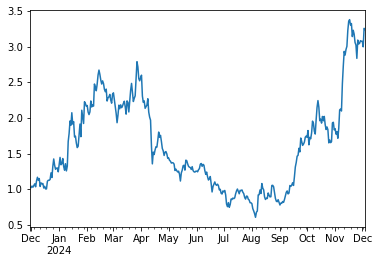

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()